**Check Google Collab resource**

In [3]:
# If using GPU as accelerator
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed May 13 19:23:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# If using TPU as accelerator
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [2]:
# Check RAM usage
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


**Importing data from Google Drive**

In [7]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
GDRIVE_DATA_DIR = '/content/drive/My Drive/Colab Notebooks'
ROOT = f'{GDRIVE_DATA_DIR}/dataset_full'

In [9]:
# Sanity check
%cd $GDRIVE_DATA_DIR
%pwd

/content/drive/My Drive/Colab Notebooks


'/content/drive/My Drive/Colab Notebooks'

## Importing dependencies

In [12]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display 
from PIL import Image
import h5py
import csv
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.applications import ResNet50, VGG16
import numpy as np
from sklearn.metrics import classification_report
from skimage import transform
import random

Using TensorFlow backend.


In [0]:
# Custom library
import helpers
from helpers.DatasetCreator import DatasetCreator
from helpers.plotModel import plotModel
from helpers import split_utils
import pandas as pd
import math
from tensorflow import keras

# **Main program**

**Dataset 1:**

10 classes (10 poses)
- 730 training
- 109 testing

In [0]:
TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/training_set'
TEST_DIR = '/content/drive/My Drive/Colab Notebooks/test_set'

*CNN model 1*



In [0]:
classifier_1 = Sequential()

classifier_1.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier_1.add(MaxPooling2D(pool_size = (2, 2)))
classifier_1.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_1.add(MaxPooling2D(pool_size = (2, 2)))
classifier_1.add(Flatten())
classifier_1.add(Dense(units = 128, activation = 'relu'))
classifier_1.add(Dense(units = 10, activation = 'softmax')) # number of classes
classifier_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [0]:
# Data Augmentation
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 20,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(TRAIN_DIR,
                                                 target_size = (64, 64),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(TEST_DIR,
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 730 images belonging to 10 classes.
Found 109 images belonging to 10 classes.


In [0]:
# Fit the model
classifier_1.compile(
              optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model_fit_1 = classifier_1.fit_generator(
                training_set,
                steps_per_epoch = 730 // batch_size, # number of training set images, 729
                epochs = 30,
                validation_data = test_set,
                validation_steps = 109 // batch_size) # number of test set images, 109

Epoch 1/30
22/22 [==============================] - 14s 615ms/step - loss: 2.2268 - accuracy: 0.2149 - val_loss: 1.6975 - val_accuracy: 0.3125
Epoch 2/30
22/22 [==============================] - 14s 655ms/step - loss: 1.9145 - accuracy: 0.3181 - val_loss: 1.9440 - val_accuracy: 0.3247
Epoch 3/30
22/22 [==============================] - 13s 574ms/step - loss: 1.5492 - accuracy: 0.4574 - val_loss: 1.7091 - val_accuracy: 0.4545
Epoch 4/30
22/22 [==============================] - 13s 582ms/step - loss: 1.3750 - accuracy: 0.5303 - val_loss: 1.8951 - val_accuracy: 0.4545
Epoch 5/30
22/22 [==============================] - 14s 615ms/step - loss: 1.3796 - accuracy: 0.5415 - val_loss: 1.5662 - val_accuracy: 0.4688
Epoch 6/30
22/22 [==============================] - 15s 684ms/step - loss: 1.1509 - accuracy: 0.6103 - val_loss: 1.9866 - val_accuracy: 0.3896
Epoch 7/30
22/22 [==============================] - 13s 612ms/step - loss: 1.1060 - accuracy: 0.6332 - val_loss: 1.1882 - val_accuracy: 0.6234

In [0]:
classifier_1.save('classifier_1.h5') #save model 

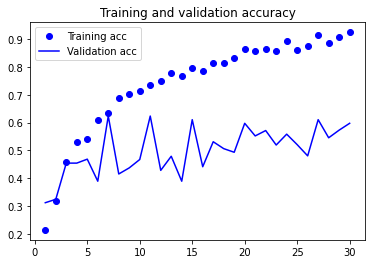

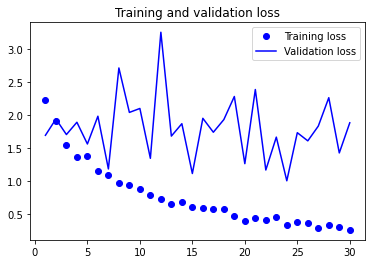

In [0]:
plotModel(model_fit_1)

*CNN model 2: Including dropout layer and one hidden layer*

In [0]:
classifier_2 = Sequential()

classifier_2.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_2.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2.add(Flatten())
classifier_2.add(Dropout(0.5))
classifier_2.add(Dense(units = 128, activation = 'relu'))
classifier_2.add(Dense(units = 10, activation = 'softmax')) # number of classes

classifier_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 128)        

In [0]:
classifier_2.compile(
              optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model_fit_2 = classifier_2.fit_generator(
                training_set,
                steps_per_epoch = 730 // batch_size, # number of training set images, 729
                epochs = 30,
                validation_data = test_set,
                validation_steps = 109 // batch_size) # number of test set images, 109

Epoch 1/30
22/22 [==============================] - 14s 638ms/step - loss: 2.2763 - accuracy: 0.2092 - val_loss: 2.2441 - val_accuracy: 0.2396
Epoch 2/30
22/22 [==============================] - 14s 635ms/step - loss: 2.2386 - accuracy: 0.2163 - val_loss: 2.2045 - val_accuracy: 0.3636
Epoch 3/30
22/22 [==============================] - 13s 601ms/step - loss: 2.1667 - accuracy: 0.2192 - val_loss: 2.1899 - val_accuracy: 0.2338
Epoch 4/30
22/22 [==============================] - 13s 591ms/step - loss: 2.0587 - accuracy: 0.2393 - val_loss: 2.1009 - val_accuracy: 0.2987
Epoch 5/30
22/22 [==============================] - 14s 637ms/step - loss: 1.9137 - accuracy: 0.3166 - val_loss: 2.0572 - val_accuracy: 0.3333
Epoch 6/30
22/22 [==============================] - 14s 649ms/step - loss: 1.8231 - accuracy: 0.3509 - val_loss: 1.7842 - val_accuracy: 0.3766
Epoch 7/30
22/22 [==============================] - 13s 580ms/step - loss: 1.5323 - accuracy: 0.4162 - val_loss: 2.0510 - val_accuracy: 0.3506

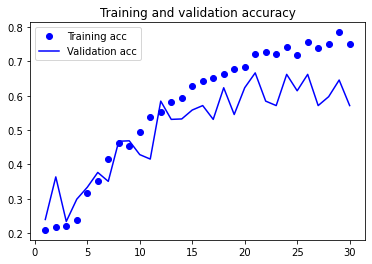

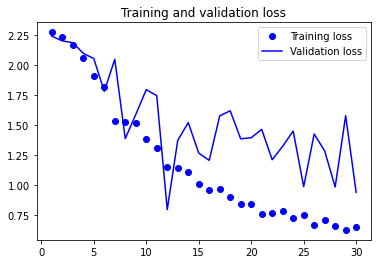

In [0]:
classifier_2.save('classifier_2.h5') #save model 
plotModel(model_fit_2)

*CNN model 3: Transfer learning from VGG16*

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))


In [0]:
classifier_3 = Sequential()
classifier_3.add(conv_base)
classifier_3.add(Flatten())
classifier_3.add(Dense(128, activation='relu'))
classifier_3.add(Dense(units = 10, activation = 'softmax'))\

classifier_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 14,978,250
Trainable params: 14,978,250
Non-trainable params: 0
_________________________________________________________________


In [0]:
classifier_3.compile(
              optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model_fit_3 = classifier_3.fit_generator(
                training_set,
                steps_per_epoch = 730 // batch_size, # number of training set images, 729
                epochs = 30,
                validation_data = test_set,
                validation_steps = 109 // batch_size) # number of test set images, 109

Epoch 1/30
22/22 [==============================] - 14s 629ms/step - loss: 2.4907 - accuracy: 0.1991 - val_loss: 2.1140 - val_accuracy: 0.2708
Epoch 2/30
22/22 [==============================] - 14s 658ms/step - loss: 2.2417 - accuracy: 0.2034 - val_loss: 2.1403 - val_accuracy: 0.2468
Epoch 3/30
22/22 [==============================] - 13s 586ms/step - loss: 2.2686 - accuracy: 0.1862 - val_loss: 2.2321 - val_accuracy: 0.3117
Epoch 4/30
22/22 [==============================] - 13s 607ms/step - loss: 2.2073 - accuracy: 0.2178 - val_loss: 2.0747 - val_accuracy: 0.2727
Epoch 5/30
22/22 [==============================] - 14s 633ms/step - loss: 2.2042 - accuracy: 0.2344 - val_loss: 2.1041 - val_accuracy: 0.2812
Epoch 6/30
22/22 [==============================] - 14s 642ms/step - loss: 2.1767 - accuracy: 0.2269 - val_loss: 1.9589 - val_accuracy: 0.3247
Epoch 7/30
22/22 [==============================] - 13s 613ms/step - loss: 2.1011 - accuracy: 0.2472 - val_loss: 2.0942 - val_accuracy: 0.2208

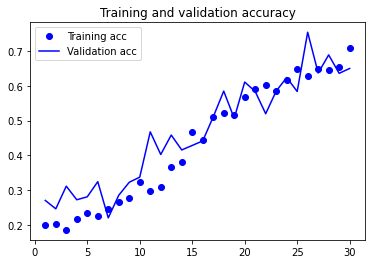

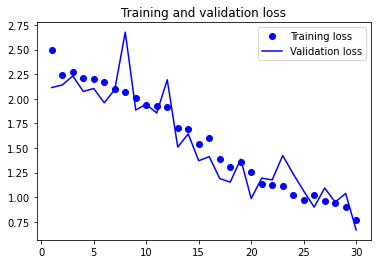

In [0]:
classifier_3.save('classifier_3.h5') #save model 
plotModel(model_fit_3)

*CNN model 4: Transfer learning from ResNet*

In [0]:
from keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


In [0]:
classifier_4 = Sequential()
classifier_4.add(conv_base)
classifier_4.add(Flatten())
classifier_4.add(Dense(128, activation='relu'))
classifier_4.add(Dense(units = 10, activation = 'softmax'))\

classifier_4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 24,637,706
Trainable params: 24,584,586
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
classifier_4.compile(
              optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model_fit_4 = classifier_4.fit_generator(
                training_set,
                steps_per_epoch = 730 // batch_size, # number of training set images, 729
                epochs = 100,
                validation_data = test_set,
                validation_steps = 109 // batch_size) # number of test set images, 109

Epoch 1/100
22/22 [==============================] - 25s 1s/step - loss: 2.3261 - accuracy: 0.3754 - val_loss: 3.5140 - val_accuracy: 0.0729
Epoch 2/100
22/22 [==============================] - 14s 657ms/step - loss: 1.1609 - accuracy: 0.6203 - val_loss: 10.1842 - val_accuracy: 0.2597
Epoch 3/100
22/22 [==============================] - 13s 606ms/step - loss: 0.8351 - accuracy: 0.7120 - val_loss: 5.3200 - val_accuracy: 0.2468
Epoch 4/100
22/22 [==============================] - 13s 586ms/step - loss: 0.5997 - accuracy: 0.7940 - val_loss: 3.8194 - val_accuracy: 0.1558
Epoch 5/100
22/22 [==============================] - 15s 660ms/step - loss: 0.4916 - accuracy: 0.8237 - val_loss: 2.8550 - val_accuracy: 0.1562
Epoch 6/100
22/22 [==============================] - 15s 672ms/step - loss: 0.4952 - accuracy: 0.8438 - val_loss: 2.3630 - val_accuracy: 0.1039
Epoch 7/100
22/22 [==============================] - 14s 620ms/step - loss: 0.4111 - accuracy: 0.8711 - val_loss: 2.5728 - val_accuracy: 0

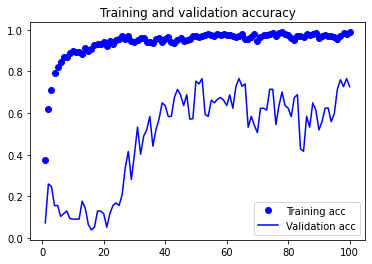

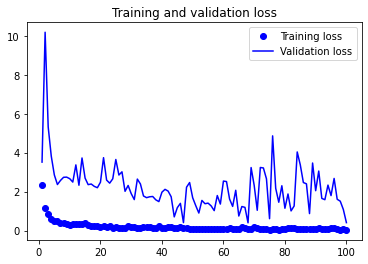

In [0]:
classifier_4.save('classifier_4.h5') #save model 
plotModel(model_fit_4)

**Dataset 2 (Sam's):**

17 classes
*   1161 training images
*   137 testing images



In [0]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/dataset trimmed'

In [0]:
batch_size = 64 

validation_split = 0.1
colorMode = 'rgb'
classMode = "categorical"
imgSize = 64

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = split_utils.train_valid_split(DATA_DIR, validation_split, seed=1)

# generator for train data
train_datagen = ImageDataGenerator(
    rescale=1./255,    
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_set_2 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(imgSize, imgSize),
    color_mode=colorMode,
    class_mode=classMode,
    batch_size=batch_size,
)

# generator for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_set_2 = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(imgSize, imgSize),
    color_mode=colorMode,
    class_mode=classMode,
    batch_size=batch_size,
    )

print('The ratio of validation_split is {}'.format(validation_split))
print('The size of train_dir is {}'.format(train_set_2.n))
print('The size of val_dir is {}'.format(validation_set_2.n))

Found 1161 images belonging to 17 classes.
Found 137 images belonging to 17 classes.
The ratio of validation_split is 0.1
The size of train_dir is 1161
The size of val_dir is 137


In [0]:
num_class = 17

# CNN 1
classifier_1s = Sequential()
classifier_1s.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier_1s.add(MaxPooling2D(pool_size = (2, 2)))
classifier_1s.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_1s.add(MaxPooling2D(pool_size = (2, 2)))
classifier_1s.add(Flatten())
classifier_1s.add(Dense(units = 128, activation = 'relu'))
classifier_1s.add(Dense(units = num_class, activation = 'softmax')) # number of classes
#classifier_1.summary()

# CNN 2
classifier_2s = Sequential()
classifier_2s.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier_2s.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2s.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_2s.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2s.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_2s.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2s.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_2s.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2s.add(Flatten())
classifier_2s.add(Dropout(0.5))
classifier_2s.add(Dense(units = 128, activation = 'relu'))
classifier_2s.add(Dense(units = num_class, activation = 'softmax')) # number of classes

# CNN 3
conv_base1 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3))

classifier_3s = Sequential()
classifier_3s.add(conv_base1)
classifier_3s.add(Flatten())
classifier_3s.add(Dense(128, activation='relu'))
classifier_3s.add(Dense(units = num_class, activation = 'softmax'))\
#classifier_3.summary()

# CNN 4
conv_base2 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3))

classifier_4s = Sequential()
classifier_4s.add(conv_base2)
classifier_4s.add(Flatten())
classifier_4s.add(Dense(128, activation='relu'))
classifier_4s.add(Dense(units = num_class, activation = 'softmax'))\
#classifier_4.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/100
15/18 [========================>.....] - ETA: 1s - loss: 2.8604 - accuracy: 0.0807

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


18/18 [==============================] - 8s 462ms/step - loss: 2.8494 - accuracy: 0.0957 - val_loss: 2.7551 - val_accuracy: 0.2734

Epoch 00001: val_accuracy improved from -inf to 0.27344, saving model to classifier_1s.h5
Epoch 2/100
18/18 [==============================] - 8s 469ms/step - loss: 2.6675 - accuracy: 0.2106 - val_loss: 2.5159 - val_accuracy: 0.2603

Epoch 00002: val_accuracy did not improve from 0.27344
Epoch 3/100
18/18 [==============================] - 8s 430ms/step - loss: 2.2434 - accuracy: 0.3318 - val_loss: 1.4264 - val_accuracy: 0.4521

Epoch 00003: val_accuracy improved from 0.27344 to 0.45205, saving model to classifier_1s.h5
Epoch 4/100
18/18 [==============================] - 8s 459ms/step - loss: 1.9513 - accuracy: 0.4202 - val_loss: 1.9345 - val_accuracy: 0.4297

Epoch 00004: val_accuracy did not improve from 0.45205
Epoch 5/100
18/18 [==============================] - 9s 473ms/step - loss: 1.7990 - accuracy: 0.4676 - val_loss: 1.5848 - val_accuracy: 0.5205


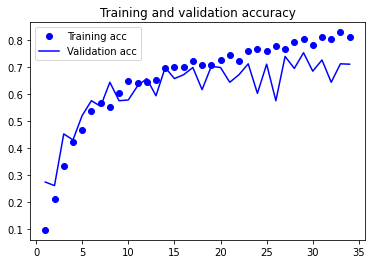

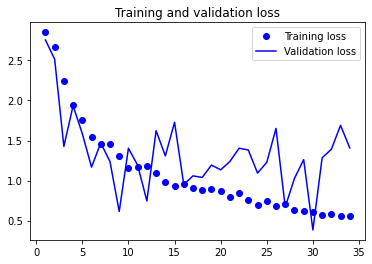

Epoch 1/100
18/18 [==============================] - 8s 466ms/step - loss: 2.8375 - accuracy: 0.0620 - val_loss: 2.8211 - val_accuracy: 0.0703

Epoch 00001: val_accuracy improved from -inf to 0.07031, saving model to classifier_2s.h5
Epoch 2/100
18/18 [==============================] - 9s 474ms/step - loss: 2.8264 - accuracy: 0.0711 - val_loss: 2.8208 - val_accuracy: 0.0822

Epoch 00002: val_accuracy improved from 0.07031 to 0.08219, saving model to classifier_2s.h5
Epoch 3/100
18/18 [==============================] - 8s 418ms/step - loss: 2.8097 - accuracy: 0.0802 - val_loss: 2.7989 - val_accuracy: 0.1507

Epoch 00003: val_accuracy improved from 0.08219 to 0.15068, saving model to classifier_2s.h5
Epoch 4/100
18/18 [==============================] - 8s 460ms/step - loss: 2.6973 - accuracy: 0.1550 - val_loss: 2.5804 - val_accuracy: 0.2109

Epoch 00004: val_accuracy improved from 0.15068 to 0.21094, saving model to classifier_2s.h5
Epoch 5/100
18/18 [==============================] - 9s

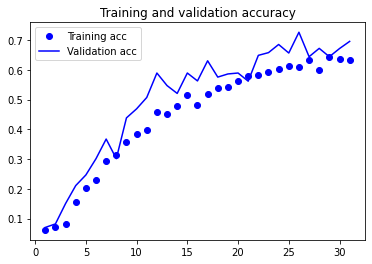

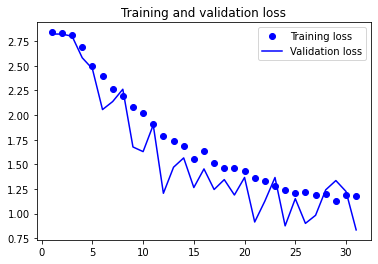

Epoch 1/100
18/18 [==============================] - 9s 491ms/step - loss: 3.5650 - accuracy: 0.0712 - val_loss: 2.8525 - val_accuracy: 0.0703

Epoch 00001: val_accuracy improved from -inf to 0.07031, saving model to classifier_3s.h5
Epoch 2/100
18/18 [==============================] - 8s 458ms/step - loss: 2.8535 - accuracy: 0.0624 - val_loss: 2.8397 - val_accuracy: 0.0959

Epoch 00002: val_accuracy improved from 0.07031 to 0.09589, saving model to classifier_3s.h5
Epoch 3/100
18/18 [==============================] - 8s 462ms/step - loss: 2.8454 - accuracy: 0.0738 - val_loss: 2.7814 - val_accuracy: 0.0685

Epoch 00003: val_accuracy did not improve from 0.09589
Epoch 4/100
18/18 [==============================] - 9s 481ms/step - loss: 2.8437 - accuracy: 0.0686 - val_loss: 2.8344 - val_accuracy: 0.0703

Epoch 00004: val_accuracy did not improve from 0.09589
Epoch 5/100
18/18 [==============================] - 8s 453ms/step - loss: 2.8434 - accuracy: 0.0701 - val_loss: 2.8407 - val_accur

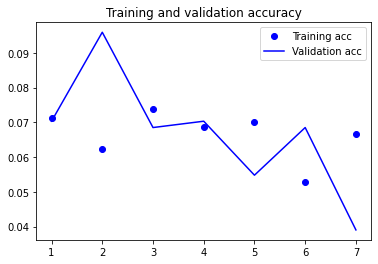

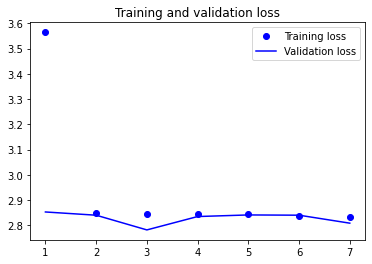

Epoch 1/100
18/18 [==============================] - 22s 1s/step - loss: 2.4681 - accuracy: 0.3263 - val_loss: 10.4927 - val_accuracy: 0.0703

Epoch 00001: val_accuracy improved from -inf to 0.07031, saving model to classifier_4s.h5
Epoch 2/100
18/18 [==============================] - 9s 476ms/step - loss: 1.3300 - accuracy: 0.6080 - val_loss: 8.7721 - val_accuracy: 0.0411

Epoch 00002: val_accuracy did not improve from 0.07031
Epoch 3/100
18/18 [==============================] - 9s 501ms/step - loss: 1.0803 - accuracy: 0.6782 - val_loss: 3.9060 - val_accuracy: 0.0274

Epoch 00003: val_accuracy did not improve from 0.07031
Epoch 4/100
18/18 [==============================] - 9s 486ms/step - loss: 0.8803 - accuracy: 0.7211 - val_loss: 6.8994 - val_accuracy: 0.0625

Epoch 00004: val_accuracy did not improve from 0.07031
Epoch 5/100
18/18 [==============================] - 9s 486ms/step - loss: 0.8768 - accuracy: 0.7566 - val_loss: 10.2053 - val_accuracy: 0.0411

Epoch 00005: val_accuracy

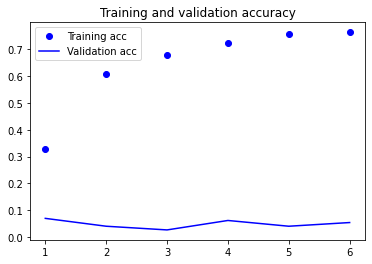

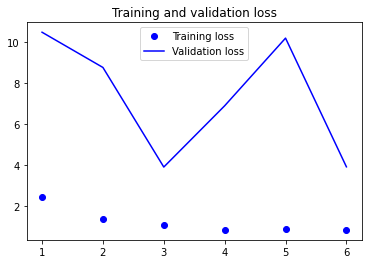

In [0]:
batch_size = 64 # Since this is running on powerful GPU

classifiers = [classifier_1s, classifier_2s, classifier_3s, classifier_4s,]
classifier_names = ['classifier_1s.h5','classifier_2s.h5','classifier_3s.h5','classifier_4s.h5']

early_stop = EarlyStopping(
      monitor='val_accuracy',
      min_delta=0.001,
      patience=5)

for classifier, classifier_name in zip(classifiers,classifier_names):
  classifier.compile(
      optimizer = 'adam', 
      loss = 'categorical_crossentropy', 
      metrics = ['accuracy'])

  checkpoint = ModelCheckpoint(filepath = classifier_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  callbacks_list = [early_stop, checkpoint]

  model_fit = classifier.fit_generator(
      train_set_2,
      steps_per_epoch = 1161 // batch_size, # number of training set images, 1161
      epochs = 100,
      validation_data = validation_set_2,
      validation_steps = 137 // batch_size,
      callbacks = callbacks_list) # number of test set images, 137
  
  plotModel(model_fit)


**Dataset 3: (not tested)**

107 classes (107 poses)
- 5353 training
- 641 testing

In [0]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/dataset_full'

In [0]:
batch_size = 128 

validation_split = 0.1
colorMode = 'rgb'
classMode = "categorical"
imgSize = 64

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = split_utils.train_valid_split(DATA_DIR, validation_split, seed=1)

# generator for train data
train_datagen = ImageDataGenerator(
    rescale=1./255,    
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_set_2 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(imgSize, imgSize),
    color_mode=colorMode,
    class_mode=classMode,
    batch_size=batch_size,
)

# generator for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_set_2 = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(imgSize, imgSize),
    color_mode=colorMode,
    class_mode=classMode,
    batch_size=batch_size,
    )

print('The ratio of validation_split is {}'.format(validation_split))
print('The size of train_dir is {}'.format(train_set_2.n))
print('The size of val_dir is {}'.format(validation_set_2.n))

Found 5353 images belonging to 107 classes.
Found 641 images belonging to 107 classes.
The ratio of validation_split is 0.1
The size of train_dir is 5353
The size of val_dir is 641


In [0]:
num_class = 107

# CNN 1
classifier_1b = Sequential()
classifier_1b.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier_1b.add(MaxPooling2D(pool_size = (2, 2)))
classifier_1b.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier_1b.add(MaxPooling2D(pool_size = (2, 2)))
classifier_1b.add(Flatten())
classifier_1b.add(Dense(units = 128, activation = 'relu'))
classifier_1b.add(Dense(units = num_class, activation = 'softmax')) # number of classes
#classifier_1.summary()

# CNN 2
classifier_2b = Sequential()
classifier_2b.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier_2b.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2b.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_2b.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2b.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_2b.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2b.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_2b.add(MaxPooling2D(pool_size = (2, 2)))
classifier_2b.add(Flatten())
classifier_2b.add(Dropout(0.5))
classifier_2b.add(Dense(units = 128, activation = 'relu'))
classifier_2b.add(Dense(units = num_class, activation = 'softmax')) # number of classes

# CNN 3
conv_base1 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3))

classifier_3b = Sequential()
classifier_3b.add(conv_base1)
classifier_3b.add(Flatten())
classifier_3b.add(Dense(128, activation='relu'))
classifier_3b.add(Dense(units = num_class, activation = 'softmax'))\
#classifier_3.summary()

# CNN 4
conv_base2 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3))

classifier_4b = Sequential()
classifier_4b.add(conv_base2)
classifier_4b.add(Flatten())
classifier_4b.add(Dense(128, activation='relu'))
classifier_4b.add(Dense(units = num_class, activation = 'softmax'))\
#classifier_4.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 37 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 1/41 [..............................] - ETA: 29:34 - loss: 4.7037 - accuracy: 0.0078

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 22 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/41 [>.............................] - ETA: 28:50 - loss: 4.6730 - accuracy: 0.0117

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/41 [=>............................] - ETA: 30:39 - loss: 4.6707 - accuracy: 0.0130

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 32 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/41 [=>............................] - ETA: 29:54 - loss: 4.6693 - accuracy: 0.0156

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/41 [==>...........................] - ETA: 28:39 - loss: 4.6700 - accuracy: 0.0156

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 41 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/41 [===>..........................] - ETA: 26:37 - loss: 4.6715 - accuracy: 0.0134

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/41 [====>.........................] - ETA: 25:35 - loss: 4.6733 - accuracy: 0.0115

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


 8/41 [====>.........................] - ETA: 26:55 - loss: 4.6714 - accuracy: 0.0130

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 38 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/41 [=====>........................] - ETA: 25:45 - loss: 4.6694 - accuracy: 0.0151

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 23 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/41 [======>.......................] - ETA: 24:40 - loss: 4.6694 - accuracy: 0.0151

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 30 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/41 [=======>......................] - ETA: 23:35 - loss: 4.6701 - accuracy: 0.0137

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/41 [=======>......................] - ETA: 22:42 - loss: 4.6687 - accuracy: 0.0145

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/41 [========>.....................] - ETA: 21:58 - loss: 4.6672 - accuracy: 0.0146

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 31 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/41 [=========>....................] - ETA: 21:02 - loss: 4.6667 - accuracy: 0.0147

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/41 [=========>....................] - ETA: 20:11 - loss: 4.6664 - accuracy: 0.0153

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 39 could not be retrieved. It could be because a worker has died.
  UserWarning)


16/41 [==========>...................] - ETA: 19:21 - loss: 4.6666 - accuracy: 0.0153

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 17 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/41 [===========>..................] - ETA: 18:28 - loss: 4.6653 - accuracy: 0.0144

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 18 could not be retrieved. It could be because a worker has died.
  UserWarning)


18/41 [============>.................] - ETA: 17:38 - loss: 4.6639 - accuracy: 0.0149

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 21 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/41 [============>.................] - ETA: 16:50 - loss: 4.6618 - accuracy: 0.0141

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/41 [=============>................] - ETA: 16:03 - loss: 4.6618 - accuracy: 0.0134

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/41 [==============>...............] - ETA: 15:49 - loss: 4.6607 - accuracy: 0.0143

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 29 could not be retrieved. It could be because a worker has died.
  UserWarning)


22/41 [===============>..............] - ETA: 14:58 - loss: 4.6592 - accuracy: 0.0147

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 40 could not be retrieved. It could be because a worker has died.
  UserWarning)


23/41 [===============>..............] - ETA: 14:22 - loss: 4.6590 - accuracy: 0.0154

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)


24/41 [================>.............] - ETA: 13:32 - loss: 4.6585 - accuracy: 0.0154

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 20 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/41 [=================>............] - ETA: 12:42 - loss: 4.6573 - accuracy: 0.0151

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)


26/41 [==================>...........] - ETA: 11:51 - loss: 4.6556 - accuracy: 0.0160

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 16 could not be retrieved. It could be because a worker has died.
  UserWarning)


27/41 [==================>...........] - ETA: 11:17 - loss: 4.6552 - accuracy: 0.0160

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 36 could not be retrieved. It could be because a worker has died.
  UserWarning)


28/41 [===================>..........] - ETA: 10:26 - loss: 4.6549 - accuracy: 0.0157

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 33 could not be retrieved. It could be because a worker has died.
  UserWarning)


29/41 [====================>.........] - ETA: 9:48 - loss: 4.6542 - accuracy: 0.0157 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


30/41 [====================>.........] - ETA: 8:56 - loss: 4.6537 - accuracy: 0.0160

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


31/41 [=====================>........] - ETA: 8:06 - loss: 4.6519 - accuracy: 0.0167

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


32/41 [======================>.......] - ETA: 7:16 - loss: 4.6503 - accuracy: 0.0172

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 34 could not be retrieved. It could be because a worker has died.
  UserWarning)


33/41 [=======================>......] - ETA: 6:27 - loss: 4.6484 - accuracy: 0.0183

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


34/41 [=======================>......] - ETA: 5:37 - loss: 4.6464 - accuracy: 0.0187

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 25 could not be retrieved. It could be because a worker has died.
  UserWarning)


35/41 [========================>.....] - ETA: 4:49 - loss: 4.6449 - accuracy: 0.0195

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 35 could not be retrieved. It could be because a worker has died.
  UserWarning)


36/41 [=========================>....] - ETA: 4:00 - loss: 4.6435 - accuracy: 0.0194

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 27 could not be retrieved. It could be because a worker has died.
  UserWarning)


37/41 [==========================>...] - ETA: 3:16 - loss: 4.6415 - accuracy: 0.0195

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


38/41 [==========================>...] - ETA: 2:27 - loss: 4.6395 - accuracy: 0.0196

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 28 could not be retrieved. It could be because a worker has died.
  UserWarning)


39/41 [===========================>..] - ETA: 1:40 - loss: 4.6375 - accuracy: 0.0195

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 26 could not be retrieved. It could be because a worker has died.
  UserWarning)


40/41 [============================>.] - ETA: 49s - loss: 4.6361 - accuracy: 0.0196 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/41 [==============================] - 2043s 50s/step - loss: 4.6325 - accuracy: 0.0203 - val_loss: 4.4647 - val_accuracy: 0.0594

Epoch 00001: val_accuracy improved from -inf to 0.05937, saving model to classifier_1b.h5
Epoch 2/50


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/41 [==============================] - 82s 2s/step - loss: 4.2963 - accuracy: 0.0775 - val_loss: 3.8887 - val_accuracy: 0.1559

Epoch 00002: val_accuracy improved from 0.05937 to 0.15595, saving model to classifier_1b.h5
Epoch 3/50
41/41 [==============================] - 39s 947ms/step - loss: 3.8011 - accuracy: 0.1499 - val_loss: 3.4656 - val_accuracy: 0.2125

Epoch 00003: val_accuracy improved from 0.15595 to 0.21248, saving model to classifier_1b.h5
Epoch 4/50
41/41 [==============================] - 38s 932ms/step - loss: 3.4683 - accuracy: 0.2170 - val_loss: 3.1231 - val_accuracy: 0.2788

Epoch 00004: val_accuracy improved from 0.21248 to 0.27875, saving model to classifier_1b.h5
Epoch 5/50
41/41 [==============================] - 38s 923ms/step - loss: 3.1854 - accuracy: 0.2614 - val_loss: 2.9205 - val_accuracy: 0.2865

Epoch 00005: val_accuracy improved from 0.27875 to 0.28655, saving model to classifier_1b.h5
Epoch 6/50
41/41 [==============================] - 38s 939ms/step

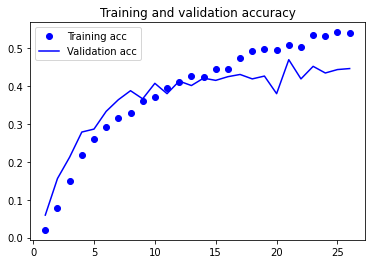

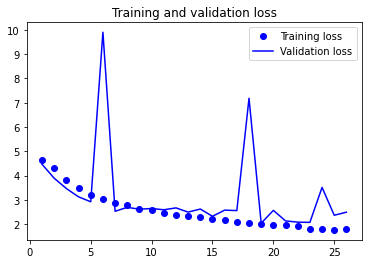

Epoch 1/50
41/41 [==============================] - 39s 950ms/step - loss: 4.6707 - accuracy: 0.0130 - val_loss: 4.6448 - val_accuracy: 0.0141

Epoch 00001: val_accuracy improved from -inf to 0.01406, saving model to classifier_2b.h5
Epoch 2/50
41/41 [==============================] - 41s 1s/step - loss: 4.6480 - accuracy: 0.0149 - val_loss: 4.5738 - val_accuracy: 0.0331

Epoch 00002: val_accuracy improved from 0.01406 to 0.03314, saving model to classifier_2b.h5
Epoch 3/50
41/41 [==============================] - 39s 956ms/step - loss: 4.5544 - accuracy: 0.0293 - val_loss: 4.3087 - val_accuracy: 0.0409

Epoch 00003: val_accuracy improved from 0.03314 to 0.04094, saving model to classifier_2b.h5
Epoch 4/50
41/41 [==============================] - 39s 944ms/step - loss: 4.3588 - accuracy: 0.0440 - val_loss: 4.0943 - val_accuracy: 0.0936

Epoch 00004: val_accuracy improved from 0.04094 to 0.09357, saving model to classifier_2b.h5
Epoch 5/50
41/41 [==============================] - 38s 92

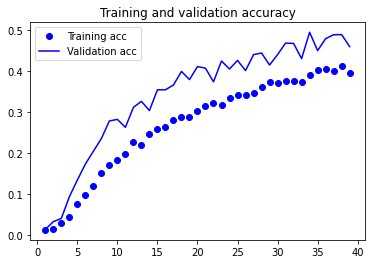

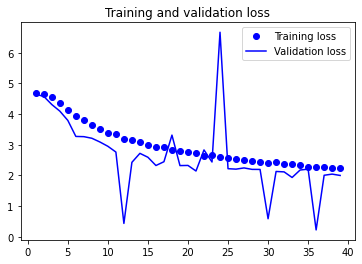

Epoch 1/50
41/41 [==============================] - 39s 955ms/step - loss: 4.6857 - accuracy: 0.0105 - val_loss: 4.6641 - val_accuracy: 0.0141

Epoch 00001: val_accuracy improved from -inf to 0.01406, saving model to classifier_3b.h5
Epoch 2/50
41/41 [==============================] - 42s 1s/step - loss: 4.6637 - accuracy: 0.0117 - val_loss: 4.6598 - val_accuracy: 0.0117

Epoch 00002: val_accuracy did not improve from 0.01406
Epoch 3/50
41/41 [==============================] - 40s 967ms/step - loss: 4.6545 - accuracy: 0.0153 - val_loss: 4.6644 - val_accuracy: 0.0136

Epoch 00003: val_accuracy did not improve from 0.01406
Epoch 4/50
41/41 [==============================] - 38s 936ms/step - loss: 4.6465 - accuracy: 0.0181 - val_loss: 4.6771 - val_accuracy: 0.0156

Epoch 00004: val_accuracy improved from 0.01406 to 0.01559, saving model to classifier_3b.h5
Epoch 5/50
41/41 [==============================] - 38s 929ms/step - loss: 4.5645 - accuracy: 0.0256 - val_loss: 4.4705 - val_accuracy

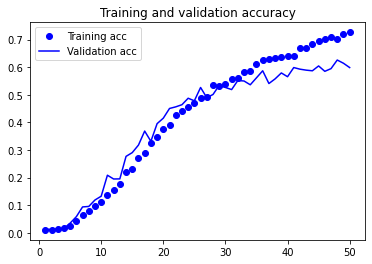

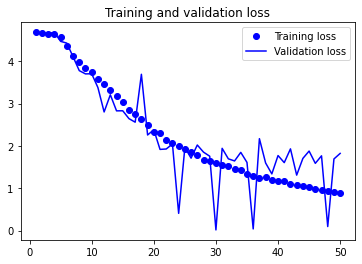

Epoch 1/50
41/41 [==============================] - 50s 1s/step - loss: 4.4375 - accuracy: 0.0670 - val_loss: 4.8558 - val_accuracy: 0.0141

Epoch 00001: val_accuracy improved from -inf to 0.01406, saving model to classifier_4b.h5
Epoch 2/50
41/41 [==============================] - 43s 1s/step - loss: 3.2589 - accuracy: 0.2448 - val_loss: 4.6725 - val_accuracy: 0.0117

Epoch 00002: val_accuracy did not improve from 0.01406
Epoch 3/50
41/41 [==============================] - 41s 994ms/step - loss: 2.3441 - accuracy: 0.4027 - val_loss: 4.6719 - val_accuracy: 0.0058

Epoch 00003: val_accuracy did not improve from 0.01406
Epoch 4/50
41/41 [==============================] - 39s 948ms/step - loss: 1.8729 - accuracy: 0.5051 - val_loss: 5.7885 - val_accuracy: 0.0136

Epoch 00004: val_accuracy did not improve from 0.01406
Epoch 5/50
41/41 [==============================] - 39s 949ms/step - loss: 1.6623 - accuracy: 0.5445 - val_loss: 5.5782 - val_accuracy: 0.0175

Epoch 00005: val_accuracy impro

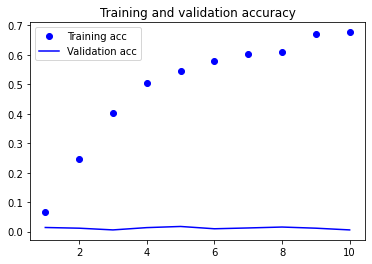

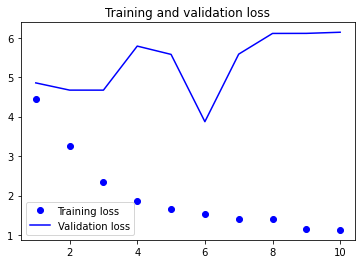

In [0]:
batch_size = 128 # Since this is running on powerful GPU

classifiers = [classifier_1b, classifier_2b, classifier_3b, classifier_4b,]
classifier_names = ['classifier_1b.h5','classifier_2b.h5','classifier_3b.h5','classifier_4b.h5']

early_stop = EarlyStopping(
      monitor='val_accuracy',
      min_delta=0.001,
      patience=5)

for classifier, classifier_name in zip(classifiers,classifier_names):
  classifier.compile(
      optimizer = 'adam', 
      loss = 'categorical_crossentropy', 
      metrics = ['accuracy'])

  checkpoint = ModelCheckpoint(filepath = classifier_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  callbacks_list = [early_stop, checkpoint]

  model_fit = classifier.fit_generator(
      train_set_2,
      steps_per_epoch = 5353 // batch_size, # number of training set images, 5353
      epochs = 50,
      validation_data = validation_set_2,
      validation_steps = 641 // batch_size,
      callbacks = callbacks_list) # number of test set images, 641
  
  plotModel(model_fit)


# Experiment w/ Tom's transfer learning

In [0]:
N_CLASSES = 17

In [0]:
creator = DatasetCreator(ROOT)

In [15]:
# here we only get the N_CLASSES most prevelant classes in the dataset
n_samples, img_files = creator.get_image_files(n=N_CLASSES) 
categorical_label_mapping = creator.categorical_mapping
n_labels = len(categorical_label_mapping)
assert(n_labels == N_CLASSES)
n_labels, n_samples

(17, 1298)

In [16]:
im_shape = (128,128,3)

X = np.zeros(shape=(tuple([n_samples] + list(im_shape))))
y = np.zeros(shape=n_samples)
idx = 0
for label, files in img_files.items():
    for f in files:
        img = np.asarray(Image.open(f))    
        X[idx,:,:,:] = transform.resize(img, im_shape)
        y[idx] = categorical_label_mapping[label]
        idx += 1
        if (idx % 100) == 0:
          print(f'Finished loading sample {idx}')

Finished loading sample 100
Finished loading sample 200
Finished loading sample 300
Finished loading sample 400
Finished loading sample 500
Finished loading sample 600
Finished loading sample 700
Finished loading sample 800
Finished loading sample 900
Finished loading sample 1000
Finished loading sample 1100
Finished loading sample 1200


In [17]:
X.shape, y.shape

((1298, 128, 128, 3), (1298,))

## EDA

label: adho mukha svanasana


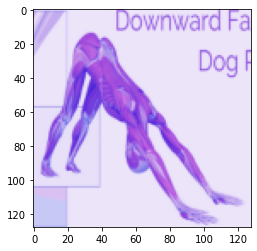

In [18]:
import matplotlib.pyplot as plt

print(f'label: {creator.get_label(int(y[-1]))}')
_ = plt.imshow(X[-1,:,:,:])

## Training

In [0]:
SEED = 42

In [20]:
import tensorflow as tf
tf.__version__

'2.2.0'

### Dataset Partitioning

In [0]:
from sklearn.model_selection import train_test_split

TEST_SET_SIZE = .2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SET_SIZE, random_state=SEED)

In [0]:
VALIDATION_SET_SIZE = 0.2

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=VALIDATION_SET_SIZE
)

train_gen.fit(X_train)

## Transfer Learning
Follows the discussion [here](https://www.tensorflow.org/tutorials/images/transfer_learning). A list of available models is in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

> One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

We want to use the feature representations (which are much richer than what we could generate from our small training set here), but optimize for our specific classification task. So, by setting `include_top` to `False` for the models we can attach a bunch of `tf.keras.layers.Dense` layers to the convolutional layers below. 

The higher (later) convolutional layers in these networks learn more specific feature mappings, whereas the initial ones are more responsible for general image feature mapping. So we can make layers on the backend of these models trainable as well.

**Note:** There are two steps here:
1. One should first train the fully connected top with _all_ the pre-trained model's layers set as non-trainable.
2. Then, we can turn those layers into trainable ones and proceed.

In [0]:
tf.keras.backend.clear_session()

In [0]:
def generate_tl_network(
    dense_layer_nodes,
    n_labels,
    pretrained_model,
    dropout_ratio=0.1
):  
    model = tf.keras.Sequential()
    model.add(pretrained_model)
    model.add(tf.keras.layers.Flatten())
    
    for n_nodes in dense_layer_nodes:
        model.add(tf.keras.layers.Dense(n_nodes, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_ratio))
    
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))
    return model

In [0]:
def decay_alpha_tl(epoch):
  DECAY_EPOCH = 100
  if epoch < DECAY_EPOCH:
    return 0.0001
  else:
    return 0.0001 * tf.math.exp(0.1 * (DECAY_EPOCH - epoch))

In [0]:
BATCH_SIZE = 16
EPOCHS = 150

In [0]:
TL_DENSE_NODES = [
    [256, 128, 64],
    [128, 128, 128],
]

**TODO** try `adam` and `sgd` with momentum for optimizers

### VGG
#### VGG16

In [27]:
vgg_base_model = tf.keras.applications.VGG16(include_top=False, input_shape=im_shape)
n_vgg_base_model_layers = len(vgg_base_model.layers)
n_vgg_base_model_layers

58892288/58889256 [==============================] - 1s 0us/step


19

##### Pre-trained model frozen

In [28]:
vgg_base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [0]:
vgg_base_model.trainable = False

In [32]:
vgg_models, vgg_results = [], []

for i, node_list in enumerate(TL_DENSE_NODES):

    print(f'Setup model with {len(node_list)} layers: {node_list}')
    m = generate_tl_network(node_list, n_labels, vgg_base_model, 0.2)
    m.compile(tf.keras.optimizers.RMSprop(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    vgg_models.append(m)
    
    r = m.fit(
        train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
        steps_per_epoch = (X_train.shape[0] * (1 - TEST_SET_SIZE - VALIDATION_SET_SIZE)) // BATCH_SIZE,
        epochs=EPOCHS,
        verbose=0,
        callbacks = [tf.keras.callbacks.LearningRateScheduler(decay_alpha_tl)],
        validation_data=train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
        validation_steps=(X_train.shape[0] * VALIDATION_SET_SIZE) // BATCH_SIZE
    )
    print(f'Finished training model: {i + 1}')
    m.evaluate(X_test, y_test, batch_size=16)
    vgg_results.append(r)

Setup model with 3 layers: [256, 128, 64]
Finished training model: 1
17/17 [==============================] - 0s 26ms/step - loss: 0.6920 - accuracy: 0.7846
Setup model with 3 layers: [128, 128, 128]
Finished training model: 2
17/17 [==============================] - 0s 15ms/step - loss: 0.7255 - accuracy: 0.7577


In [0]:
best_model_idx = 1
best_model_results = vgg_results[best_model_idx] 

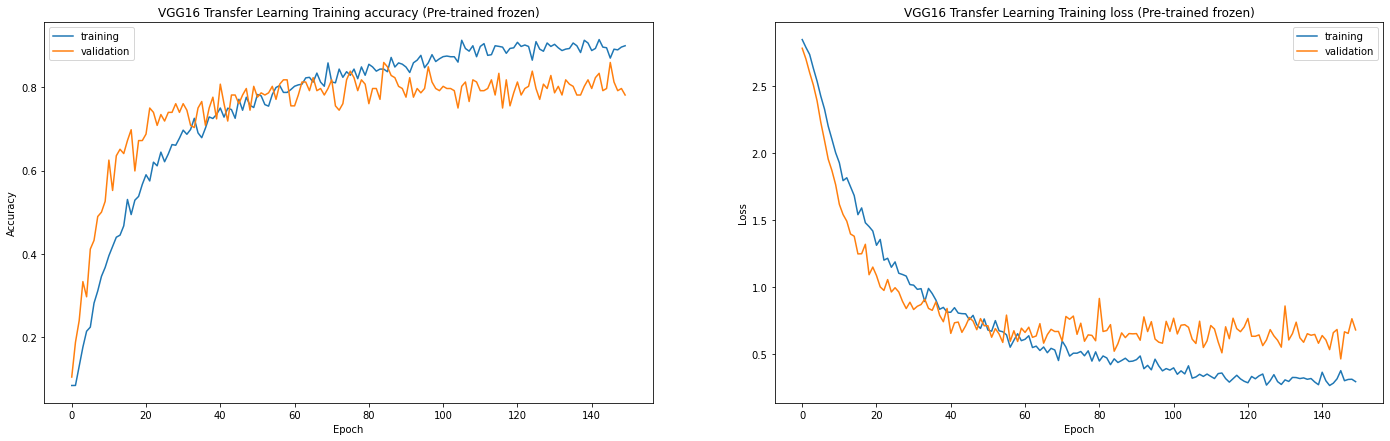

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,7))
ax1.plot(best_model_results.history['accuracy'], label='training')
ax1.plot(best_model_results.history['val_accuracy'], label='validation')
ax1.set_title('VGG16 Transfer Learning Training accuracy (Pre-trained frozen)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax2.plot(best_model_results.history['loss'], label='training')
ax2.plot(best_model_results.history['val_loss'], label='validation')
ax2.set_title('VGG16 Transfer Learning Training loss (Pre-trained frozen)')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
_ = ax2.legend()

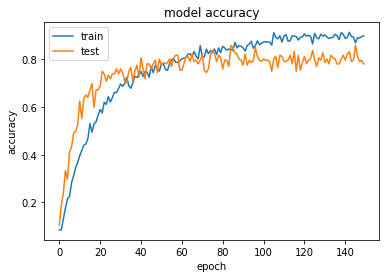

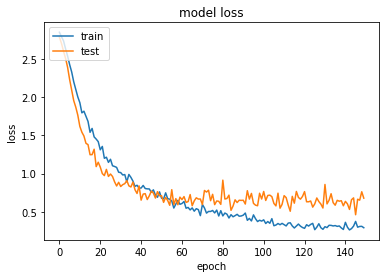

In [35]:
helpers.plotTrainingHistory(best_model_results.history)

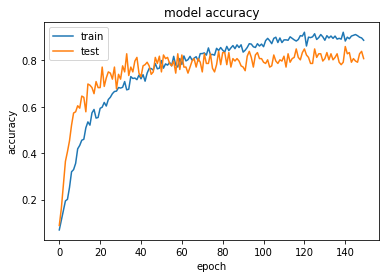

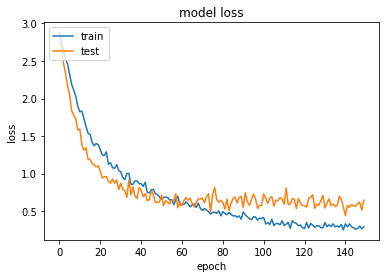

In [36]:
helpers.plotTrainingHistory(vgg_results[0].history)

##### Unfreeze pre-trained model layers

In [0]:
VGG_FINE_TUNE_LAYERS = 3
VGG_FINE_TUNE_EPOCHS = 20

In [0]:
vgg_base_model.trainable = True

In [39]:
fine_tuned_vgg_results, fine_tuned_vgg_models = [], []


for i, m in enumerate(vgg_models):
    
    for layer in vgg_base_model.layers[:n_vgg_base_model_layers-VGG_FINE_TUNE_LAYERS]:
      layer.trainable = False
    
    m.compile(tf.keras.optimizers.RMSprop(lr=0.0001 / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f'Compiled model {i+1} by unfreezing last: {VGG_FINE_TUNE_LAYERS} layers of VGG16.')
    fine_tuned_vgg_models.append(m)
    r = m.fit(
        train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
        steps_per_epoch = (X_train.shape[0] * (1 - TEST_SET_SIZE - VALIDATION_SET_SIZE)) // BATCH_SIZE,
        epochs=VGG_FINE_TUNE_EPOCHS,
        verbose=0,
        callbacks = [tf.keras.callbacks.LearningRateScheduler(decay_alpha_tl)],
        validation_data=train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
        validation_steps=(X_train.shape[0] * VALIDATION_SET_SIZE) // BATCH_SIZE
    )
    # print(f'Finished training model: {i + 1}')
    m.evaluate(X_test, y_test, batch_size=16)
    fine_tuned_vgg_results.append(r)

Compiled model 1 by unfreezing last: 3 layers of VGG16.
17/17 [==============================] - 0s 15ms/step - loss: 1.0252 - accuracy: 0.6962
Compiled model 2 by unfreezing last: 3 layers of VGG16.
17/17 [==============================] - 0s 15ms/step - loss: 1.3821 - accuracy: 0.6923


In [0]:
best_vgg_model_idx = 0
final_vgg_model = fine_tuned_vgg_models[best_vgg_model_idx]

##### Comparing fine-tuned models vs pre-trained

In [0]:
initial_epochs = EPOCHS
best_model_idx = 0

In [0]:
# Store VGG pre-trained results
acc = vgg_results[best_model_idx].history['accuracy']
val_acc = vgg_results[best_model_idx].history['val_accuracy']
loss = vgg_results[best_model_idx].history['loss']
val_loss = vgg_results[best_model_idx].history['val_loss']

# Adding fine_tune results
acc += fine_tuned_vgg_results[best_model_idx].history['accuracy']
val_acc += fine_tuned_vgg_results[best_model_idx].history['val_accuracy']
loss += fine_tuned_vgg_results[best_model_idx].history['loss']
val_loss += fine_tuned_vgg_results[best_model_idx].history['val_loss']

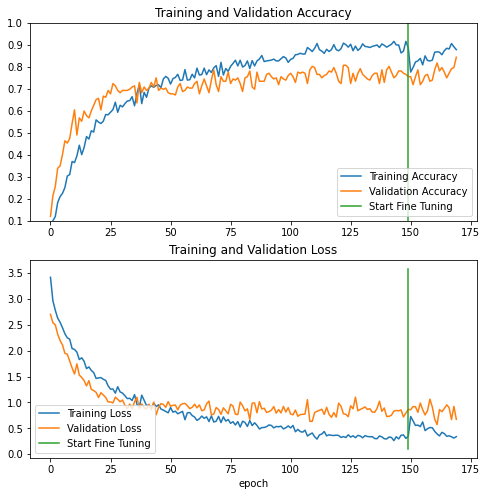

In [87]:
# Plot

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
final_vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [0]:
keras.utils.plot_model(final_vgg_model, 'VGG16.png', show_shapes=True)

##### Serialize

In [45]:
from datetime import datetime

path = f'{GDRIVE_DATA_DIR}/vgg/n_labels={n_labels}/date={datetime.now().strftime("%Y-%m-%d")}/'
final_vgg_model.save(path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/vgg/n_labels=17/date=2020-05-13/assets


### DenseNet
#### DenseNet121

In [46]:
densenet_121_base_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=im_shape)
n_densenet_base_model_layers = len(densenet_121_base_model.layers)
n_densenet_base_model_layers

29089792/29084464 [==============================] - 0s 0us/step


427

##### Pre-trained model frozen

In [0]:
densenet_121_base_model.trainable = False

In [48]:
densenet_models, densenet_results = [], []

for node_list in TL_DENSE_NODES:

  print(f'Setup model with {len(node_list)} layers: {node_list}')
  m = generate_tl_network(node_list, n_labels, densenet_121_base_model, 0.2)
  m.compile(tf.keras.optimizers.RMSprop(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  densenet_models.append(m)

  r = m.fit(
      train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
      steps_per_epoch = (X_train.shape[0] * (1 - TEST_SET_SIZE - VALIDATION_SET_SIZE)) // BATCH_SIZE,
      epochs=EPOCHS,
      verbose=0,
      callbacks = [tf.keras.callbacks.LearningRateScheduler(decay_alpha_tl)],
      validation_data=train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
      validation_steps=(X_train.shape[0] * VALIDATION_SET_SIZE) // BATCH_SIZE
  )
  print(f'Finished training model: {i + 1}')
  m.evaluate(X_test, y_test, batch_size=16)
  densenet_results.append(r)

Setup model with 3 layers: [256, 128, 64]
Finished training model: 2
17/17 [==============================] - 1s 34ms/step - loss: 0.6917 - accuracy: 0.7846
Setup model with 3 layers: [128, 128, 128]
Finished training model: 2
17/17 [==============================] - 0s 18ms/step - loss: 0.6524 - accuracy: 0.8038


In [0]:
best_model_idx = 1
best_model_results = densenet_results[best_model_idx] 

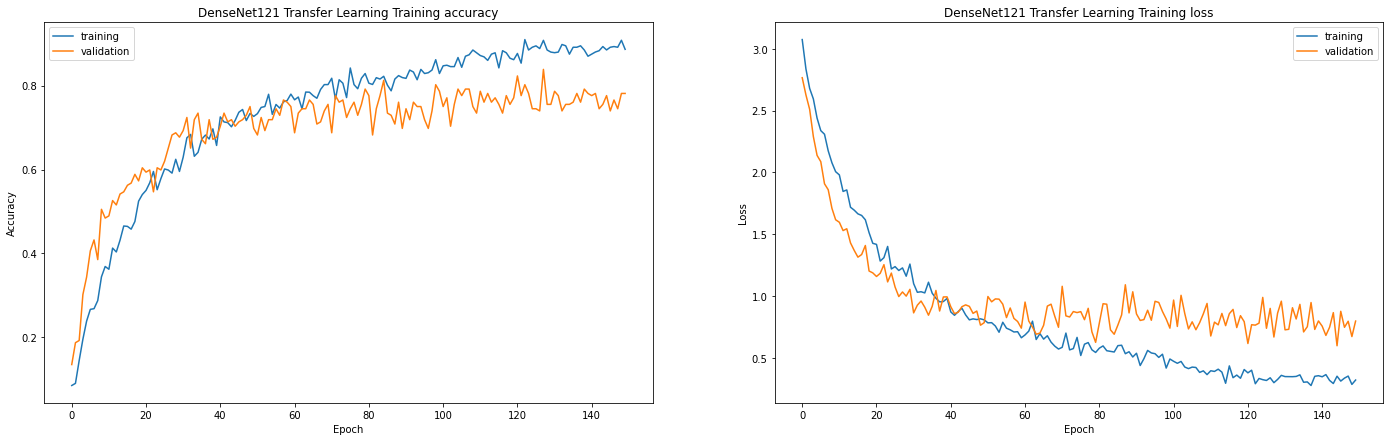

In [50]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,7))
ax1.plot(best_model_results.history['accuracy'], label='training')
ax1.plot(best_model_results.history['val_accuracy'], label='validation')
ax1.set_title('DenseNet121 Transfer Learning Training accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax2.plot(best_model_results.history['loss'], label = 'training')
ax2.plot(best_model_results.history['val_loss'], label='validation')
ax2.set_title('DenseNet121 Transfer Learning Training loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
_ = ax2.legend()

##### Unfreeze pre-trained model layers

In [0]:
densenet_121_base_model.trainable = True

In [0]:
DENSENET_FINE_TUNE_LAYERS = 100
DENSENET_FINE_TUNE_EPOCHS = 20

In [53]:
fine_tuned_densenet_results, fine_tuned_densenet_models = [], []


for i, m in enumerate(densenet_models):
    
    for layer in densenet_121_base_model.layers[:n_densenet_base_model_layers-DENSENET_FINE_TUNE_LAYERS]:
      layer.trainable = False
    
    m.compile(tf.keras.optimizers.RMSprop(lr=0.0001 / 10), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f'Compiled model {i+1} by unfreezing last: {DENSENET_FINE_TUNE_LAYERS} layers of DenseNet121.')
    fine_tuned_densenet_models.append(m)
    r = m.fit(
        train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
        steps_per_epoch = (X_train.shape[0] * (1 - TEST_SET_SIZE - VALIDATION_SET_SIZE)) // BATCH_SIZE,
        epochs=DENSENET_FINE_TUNE_EPOCHS,
        verbose=0,
        callbacks = [tf.keras.callbacks.LearningRateScheduler(decay_alpha_tl)],
        validation_data=train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
        validation_steps=(X_train.shape[0] * VALIDATION_SET_SIZE) // BATCH_SIZE
    )
    # print(f'Finished training model: {i + 1}')
    m.evaluate(X_test, y_test, batch_size=16)
    fine_tuned_densenet_results.append(r)

Compiled model 1 by unfreezing last: 100 layers of DenseNet121.
17/17 [==============================] - 0s 17ms/step - loss: 0.7908 - accuracy: 0.8000
Compiled model 2 by unfreezing last: 100 layers of DenseNet121.
17/17 [==============================] - 0s 18ms/step - loss: 0.7109 - accuracy: 0.8115


In [0]:
densenet_best_model_idx = 1
final_densenet_model = fine_tuned_densenet_models[densenet_best_model_idx]

##### Compare fine-tuned models vs pre-trained

In [0]:
initial_epochs = EPOCHS
best_model_idx = 0

In [0]:
# Store DenseNet pre-trained results
acc = densenet_results[best_model_idx].history['accuracy']
val_acc = densenet_results[best_model_idx].history['val_accuracy']
loss = densenet_results[best_model_idx].history['loss']
val_loss = densenet_results[best_model_idx].history['val_loss']

# Adding fine_tune results
acc += fine_tuned_densenet_results[best_model_idx].history['accuracy']
val_acc += fine_tuned_densenet_results[best_model_idx].history['val_accuracy']
loss += fine_tuned_densenet_results[best_model_idx].history['loss']
val_loss += fine_tuned_densenet_results[best_model_idx].history['val_loss']

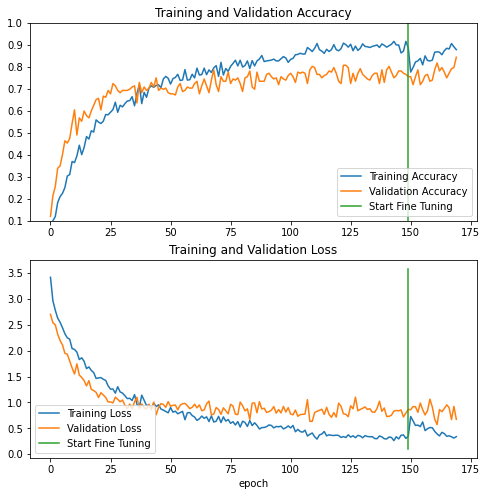

In [88]:
# Plot

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Serialize

In [55]:
path = f'{GDRIVE_DATA_DIR}/densenet/n_labels={n_labels}/date={datetime.now().strftime("%Y-%m-%d")}/'
final_densenet_model.save(path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/densenet/n_labels=17/date=2020-05-13/assets


#### Evaluation
In order to visualize our aggregate, and class-by-class, loss here we show the `classification_report` provided by the `sklearn` library. This show precision, recall and f1 for the model as a whole along with a label level breakout of each.
##### VGG

In [56]:
y_pred = final_vgg_model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

         0.0       0.77      0.85      0.81        20
         1.0       0.67      0.92      0.77        13
         2.0       0.83      0.91      0.87        22
         3.0       0.33      0.12      0.18        16
         4.0       1.00      0.85      0.92        20
         5.0       1.00      0.58      0.74        12
         6.0       1.00      0.68      0.81        19
         7.0       0.85      0.79      0.81        14
         8.0       1.00      0.50      0.67        18
         9.0       0.19      1.00      0.32        11
        10.0       0.83      0.56      0.67        18
        11.0     

In [91]:
y_test_empty = []
for i, label in enumerate(y_test):
  if label == 15.0:
    y_test_empty.append(i)

print(y_test_empty)

[2, 17, 18, 20, 27, 47, 93, 142, 183, 215, 257]


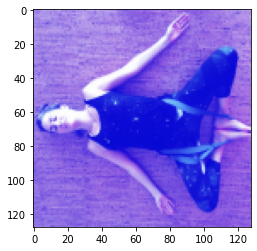

In [92]:
plt.imshow(X_test[2])

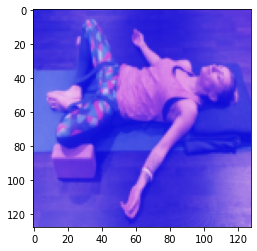

In [94]:
plt.imshow(X_test[93])

##### DenseNet

In [0]:
# Wrong model chosen
# y_pred = final_densenet_model.predict_classes(X_test)
# print(classification_report(y_test, y_pred))

In [58]:
y_pred = final_densenet_model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87        20
         1.0       0.90      0.69      0.78        13
         2.0       1.00      0.91      0.95        22
         3.0       0.67      0.38      0.48        16
         4.0       1.00      0.95      0.97        20
         5.0       0.91      0.83      0.87        12
         6.0       0.85      0.89      0.87        19
         7.0       0.93      1.00      0.97        14
         8.0       0.92      0.67      0.77        18
         9.0       0.67      0.73      0.70        11
        10.0       0.88      0.78      0.82        18
        11.0       0.89      1.00      0.94         8
        12.0       0.78      0.93      0.85        15
        13.0       0.82      0.64      0.72        14
        14.0       0.37      0.58      0.45        12
        15.0       0.58      1.00      0.73        11
        16.0       1.00      0.76      0.87        17

    accuracy              

## Prediction
Now, training loss and all that jazz is great but these things are really only useful if we can make predictions with them. Here's, how:  

In [0]:
def show_prediction(idx, model):
  true_mapping = int(y_test[idx])
  true_label = creator.get_label(true_mapping) # convert back from np.float
  print(f'ground truth: {true_mapping} -> {true_label}')
  y_pred = model.predict(np.reshape(X_test[idx], tuple([1] + list(X_test[idx].shape)))).argmax()
  pred_label = creator.get_label(int(y_pred))
  print(f'prediction: {int(y_pred)} -> {pred_label}')
  plt.imshow(X_test[idx])
  return

### VGG

ground truth: 8 -> bhujangasana
prediction: 9 -> balasana


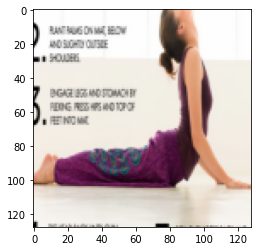

In [60]:
show_prediction(3, final_vgg_model)

ground truth: 8 -> bhujangasana
prediction: 8 -> bhujangasana


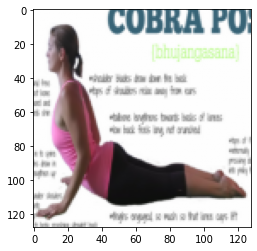

In [61]:
show_prediction(37, final_vgg_model)

ground truth: 13 -> supta baddha konasana
prediction: 13 -> supta baddha konasana


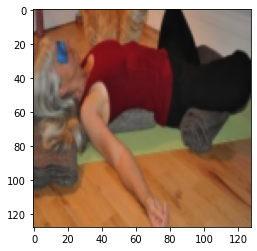

In [62]:
show_prediction(49, final_vgg_model)

ground truth: 16 -> adho mukha svanasana
prediction: 16 -> adho mukha svanasana


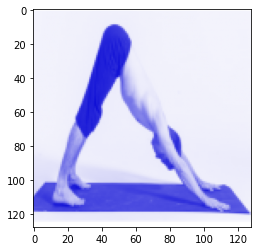

In [63]:
show_prediction(101, final_vgg_model)

### Densenet

ground truth: 15 -> baddha konasana
prediction: 15 -> baddha konasana


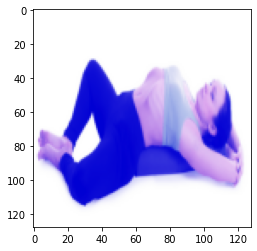

In [64]:
show_prediction(17, final_vgg_model)

ground truth: 3 -> bitilasana
prediction: 14 -> chakravakasana


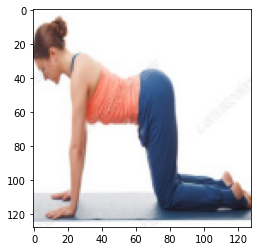

In [65]:
show_prediction(42, final_vgg_model)

ground truth: 10 -> gomukhasana
prediction: 0 -> ardha matsyendrasana


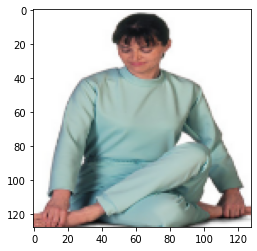

In [66]:
show_prediction(29, final_vgg_model)

ground truth: 4 -> garudasana
prediction: 7 -> utkatasana


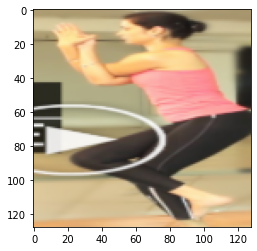

In [67]:
show_prediction(51, final_vgg_model)

ground truth: 10 -> gomukhasana
prediction: 0 -> ardha matsyendrasana


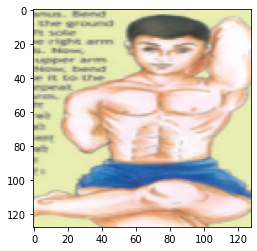

In [68]:
show_prediction(97, final_vgg_model)